# CopyCat: Example Usage on Argsme

This notebook assumes that you have a jupyter notebook with CopyCat installed.
To start a jupyter notebook with CopyCat installed and your local directory mounted, run:
```
docker run --rm -ti -v ${PWD}:/home/jovyan -p 8888:8888 webis/chatnoir-copycat:1.0-jupyter
```


Then, we use the CopyCat cli to deduplicate run files submitted to the [Touché](https://webis.de/events/touche-20/) shared task on argument retrieval. The corpus of the shared task is the [args.me corpus](https://zenodo.org/record/3734893#.YETkhiso_rk), which contains 387,740 arguments crawled from  four debate portals (debatewise.org, idebate.org, debatepedia.org, anddebate.org).

## Step 1: Download the argsme anserini index

The following code downloads the argsme index for Anserini that we use for the deduplication analysis on the argsme corpus.

In [1]:
import os.path
INDEX='copycat-on-argsme-data/index'
RUN_DIR='copycat-on-argsme-data/touche-runs-task1-2020/touche-runs-task1-2020/runs-task-1/touche-2020-first-task-dataset-v2/'

!mkdir -p copycat-on-argsme-data
if not os.path.isfile('copycat-on-argsme-data/argsme-index.tar.gz') or not os.path.isdir(INDEX):
    !wget -O copycat-on-argsme-data/argsme-index.tar.gz 'https://files.webis.de/data-in-progress/touche20/argsme-anserini-premise-conclusion-porter-stemmer.tar.gz'
    !tar -xvzf copycat-on-argsme-data/argsme-index.tar.gz -C copycat-on-argsme-data
    
    !wget -O copycat-on-argsme-data/touche-runs-task1-2020.zip  'https://files.webis.de/data-in-progress/touche20/touche-runs-task1-2020.zip'
    !unzip copycat-on-argsme-data/touche-runs-task1-2020.zip -d $RUN_DIR
else:
    print('Argsme index is already downloaded.')


Argsme index is already downloaded.


# Step 2: Verify the Download; Double Check the Document Preprocessing

We have double-checked the preprocessing for the ClueWebs and CommonCrawls by many unit and integration tests.
Since the argsme dataset is not included in these tests, we have to double-check the preprocessing using some examples. (Please [see here](https://github.com/chatnoir-eu/copycat/blob/master/copycat-modules/document-preprocessing/README.md) for an overview of preprocessing options.)

To verify the preprocessing, we check a few documents manually.

In [2]:
# Use CopyCat to check the preprocessing for a single document

!copy-cat \
    --retrieveDocId S1a76ed9f-A25eafb83 \
    --documents AnseriniIndex \
    --anseriniIndex $INDEX \
    --keepStopwords True \
    --output a --input a

argument flaw current systemtest score nation center fair open test nft 1 note mani school focu littl too much test score teacher evalu order get grant from child left behind so school real reason behind give test score too much worth when come teacher evalu actual accuraci evalu opportun obtain grant principl review thi veri obviou teacher can easili chang up regular wai teach moment principl walk i see thi all time teacher i have had.of cour both factor should go awai clear someth miss nft explain measur teacher princip qualiti effect u multipl measur base school classroom evid accuraci student evaluationsstud evalu ar just what high school need correctli ass teacher abil atlant cite studi perform variou teacher evalu fill out student 2 evalu were prove much more accur than ani known wai assess instructor abil thi studi wa abl show teacher high rate were abl fit six more month learn than teacher lowest rate thi show student don’t alwai give teacher high rate becau thei like easi clas

The preprocessed argsme document `S1a76ed9f-A25eafb83` loogs good (stemming as expected, no problems with encoding, etc.).

## Step 3: Deduplicate all run files submitted to Touché

Now that we have double-checked that the document preprocessing works as expected for argsme, we can deduplicate the run files and inspect the results.

In [3]:
# this helper function executes copycat on the passed run file with the double-checked document preprocessing
def deduplicate_run_file(run_name, ranks):
    input_run_file=RUN_DIR + run_name + '.txt'
    output_file='copycat-on-argsme-data/' + run_name + '-top' + str(ranks) + '.jsonl'
    !copy-cat \
        --output $output_file \
        --input $input_run_file \
        --similarities "s3" \
        --s3Threshold 0.8 \
        --threads 5 \
        --ranks $ranks \
        --documents AnseriniIndex \
        --keepStopwords True \
        --anseriniIndex $INDEX

# Preprocess all runs
RUNS = !ls $RUN_DIR |grep run|grep txt
for run in RUNS:
    for depth in [10, 100]:
        deduplicate_run_file(run.replace('.txt', ''), depth)

The specified output 'copycat-on-argsme-data/aragorn-run-01-top10.jsonl' exists.
Skip...
The specified output 'copycat-on-argsme-data/aragorn-run-01-top100.jsonl' exists.
Skip...
The specified output 'copycat-on-argsme-data/aragorn-run-02-top10.jsonl' exists.
Skip...
The specified output 'copycat-on-argsme-data/aragorn-run-02-top100.jsonl' exists.
Skip...
The specified output 'copycat-on-argsme-data/aragorn-run-03-top10.jsonl' exists.
Skip...
The specified output 'copycat-on-argsme-data/aragorn-run-03-top100.jsonl' exists.
Skip...
The specified output 'copycat-on-argsme-data/aragorn-run-04-top10.jsonl' exists.
Skip...
The specified output 'copycat-on-argsme-data/aragorn-run-04-top100.jsonl' exists.
Skip...
The specified output 'copycat-on-argsme-data/aragorn-run-05-top10.jsonl' exists.
Skip...
The specified output 'copycat-on-argsme-data/aragorn-run-05-top100.jsonl' exists.
Skip...
The specified output 'copycat-on-argsme-data/dread-pirate-roberts-run-01-top10.jsonl' exists.
Skip...
The

## Step 4: Analyse Near-Duplicates in run files submitted to Touché

Now that we have identified near-duplicates in the top-10 and top-100 ranks of run files submitted to touche.
We use pandas and seaborn for the analysis.

In [4]:
import json
import pandas as pd
import seaborn as sns

def eval_with_threshold(threshold, run_file_name):
    rows = []
    with open(run_file_name) as jsonl_file:
        for jsonl in jsonl_file:
            dedup_data = json.loads(jsonl)
            docs_to_remove = []
            
            for sim in dedup_data['similarities']:
                if sim['similarities']['s3'] >=  threshold:
                    docs_to_remove += [sim['secondId']]

                
            rows += [{
                    'topic': dedup_data['topic'],
                    'duplicates': len(set(docs_to_remove)),
                    'docs': dedup_data['docs'],
                }]

    return rows

def eval_runs_with_threshold(threshold, run_files):
    rows = []
    for r in run_files:
        rows += eval_with_threshold(threshold, r)
    
    return pd.DataFrame(rows)

DEDUP_TARGET_DIR='copycat-on-argsme-data/'

ALL_DIRS=!ls $DEDUP_TARGET_DIR
ALL_DIRS = [DEDUP_TARGET_DIR + i for i in ALL_DIRS if 'top10.jsonl' in i]

df10 = eval_runs_with_threshold(0.82, ALL_DIRS)
df10['redundancy'] = df10['duplicates']/df10['docs']
df10['docs'] = 10

ALL_DIRS=!ls $DEDUP_TARGET_DIR
ALL_DIRS = [DEDUP_TARGET_DIR + i for i in ALL_DIRS if 'top100.jsonl' in i]

df100 = eval_runs_with_threshold(0.82, ALL_DIRS)
df100['redundancy'] = df100['duplicates']/df100['docs']
df100['docs'] = 100

df = pd.concat([df10, df100])

First, we analyse the mean number of near-duplicates in the top positions.

In [5]:
df[['docs', 'redundancy']].groupby('docs').mean()

,redundancy
docs,
10,0.014833
100,0.017621


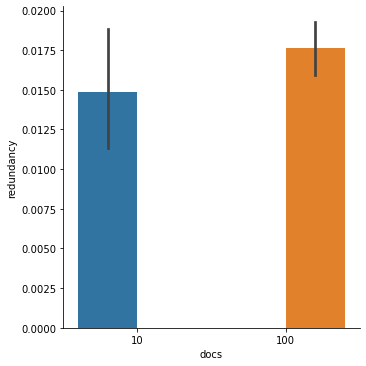

In [6]:
import seaborn as sns
sns.catplot(data=df, x='docs', y='redundancy', kind='bar', hue='docs')

## Conclusion

Overall, we see that there are only few near-duplicates in runs submitted to the Touché shared task.
This is reasonable, since the argsme dataset is a small focused crawl with 387,740 arguments.
Hence, it is reasonable that near-duplicates do not have an high impact, but still it is important that we have verified that the negative effects that duplicates can have (information leakage in train/test splits, [overfitting in LTR](https://webis.de/downloads/publications/papers/webis_2020d.pdf), [ artificially inflates performance scores](https://webis.de/downloads/publications/papers/webis_2020b.pdf)) have only negligible impact on Touché.